In [2]:
import imageio
import math
import numpy as np

In [3]:
def evaluation(stitched, original):
  '''
  Sum absolute difference
  '''
  stitched, ow, oh = pad_image(stitched, original.shape)
  total_px = ow * oh
  differents = np.count_nonzero(original - stitched[:oh,:ow])

  # percent the same
  return (total_px - differents) / total_px

In [4]:
def rot_eval(stitched, original):
    pass

In [5]:
def pad_image(stitched, target_size):
  sw, sh = stitched.shape
  tw, th = target_size

  nw, nh = (0,0)
  if sw < tw:
      nw = tw - sw
  if sh < th:
      nh = th - sh

  if nw + nh > 0:
    return (np.pad(stitched, ((0, nw), (0, nh)), 'constant', constant_values=(0,0)), tw, th)
  return (stitched, tw, th)

In [6]:
im1 = imageio.imread('../data/T1_Img_002.00.tif')

In [7]:
evaluation(im1, im1)

1.0

In [8]:
im2 = np.copy(im1)
im2[0:2048, 0:2048] = np.ones((2048, 2048), dtype='uint16')
evaluation(im1, im2)

0.7500000596046448

In [9]:
import math
def i_RMSE(stitched, original):
    total_px = len(stitched) * len(original)
    stitched = stitched.astype('float64') / (100)
    original = original.astype('float64') / (100)
    abs_err = abs(original - stitched) ** 2
    print(abs_err)
    return math.sqrt((1/total_px) * abs_err.sum())


In [10]:
import numpy as np
x = np.array([45,67,21,89,33,56])
y = np.array([23,41,45,22,67,99])

i_RMSE(x,y)

[0.0484 0.0676 0.0576 0.4489 0.1156 0.1849]


0.16012148165967266

In [11]:
def fill_fn(fn, size):
    name = fn.__name__
    if name == 'NCC':
        return np.zeros(size)
    elif name == 'SSD' or name == 'SAD' or name == 'SRD':
        return np.full(size, np.inf)

def convolve(im, template, op):
    h_len, w_len = im.shape
    th, tw = template.shape
    op_res = fill_fn(op, (h_len-1, w_len-1))
    for i in range(h_len-th+1):
        for j in range(w_len-tw+1):
            op_res[i,j] = op(im[i:i+th, j:j+tw], template)
    return np.array(op_res)

def NCC(i1, i2):
    '''
    Normalized cross correlation, maximize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    f_err = i1 - i1.mean()
    t_err = i2 - i2.mean()
    nom = (f_err * t_err).sum()
    dnom = np.square(t_err).sum() * np.square(f_err).sum()
    if math.sqrt(dnom) == 0:
        return 0
    return nom / math.sqrt(dnom)

def SSD(i1, i2):
    '''
    Sum squared differences, minimize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    sum_square = np.square(i2 - i1).sum() # (A - B)^2 
    return sum_square

def SAD(i1, i2):
    '''
    sum absolute differences, minimize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    sum_absolute = (abs(i2 - i1)).sum() # | A - B | 
    return sum_absolute

def SRD(i1, i2):
    '''
    sum robust differences, minimize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes "%s" v "%s"' % (i1.shape, i2.shape,)
    f = np.vectorize(huber_p)
    return f(i2-i1).sum()

def huber_p(u):
    c = 2**14
    if abs(u) <= c:
        return 0.5 * (u*u)
    # |u| > c
    return 0.5 * c * (2 * abs(u) - c)

In [12]:
x = np.array([[1,2],[3,4]])
x2 = np.pad(x, ((2,2),(3,2)), 'constant', constant_values=(0,0))

corr = convolve(x2, x, SSD)
_y, _x = np.unravel_index(np.argmin(corr), corr.shape)  # find the match
_y, _x

(2, 3)

In [13]:
corr

array([[30., 30., 30., 30., 30., 30.],
       [30., 30., 23., 13., 22., 30.],
       [30., 30., 12.,  0., 22., 30.],
       [30., 30., 27., 33., 38., 30.],
       [30., 30., 30., 30., 30., 30.]])

In [14]:
corr = convolve(x2, x, NCC)
_y, _x = np.unravel_index(np.argmax(corr), corr.shape)  # find the match
_y, _x

(2, 3)

In [15]:
corr

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.77459667,  0.94387981,  0.25819889,
         0.        ],
       [ 0.        ,  0.        ,  0.73029674,  1.        , -0.13483997,
         0.        ],
       [ 0.        ,  0.        , -0.25819889, -0.81409158, -0.77459667,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [16]:
corr = convolve(x2, x, SRD)
_y, _x = np.unravel_index(np.argmin(corr), corr.shape)  # find the match
_y, _x

(2, 3)

In [17]:
corr

array([[15. , 15. , 15. , 15. , 15. , 15. ],
       [15. , 15. , 11.5,  6.5, 11. , 15. ],
       [15. , 15. ,  6. ,  0. , 11. , 15. ],
       [15. , 15. , 13.5, 16.5, 19. , 15. ],
       [15. , 15. , 15. , 15. , 15. , 15. ]])

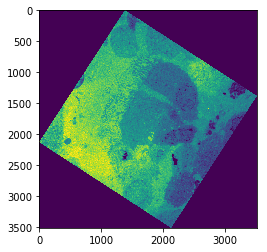

In [64]:
from PIL import Image
from scipy import ndimage

import matplotlib.pyplot as plt

def plot_im(im):
    plt.imshow(im)
    plt.show()

# ns_ref = (128,128)
ref_src = Image.open('../data/T1_segment_rot_2.tif')
ref = np.array(ref_src.copy()).astype('uint16')#.resize(ns_ref)

plot_im(ref)

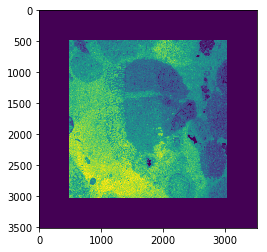

In [74]:
ref2 = ndimage.rotate(ref.copy(), 33, reshape=False, order=2)
plot_im(ref2)

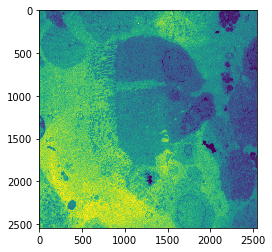

In [76]:
def crop_zeros(im, zero=0):
    # get the coordinates of every point > zero
    true_points = np.argwhere(im > zero)
    tl = true_points.min(axis=0) # top left corner
    br = true_points.max(axis=0) # bottom right corner
    out = im[tl[0]:br[0]+1,
             tl[1]:br[1]+1] 
    return out

plot_im(crop2(ref2.copy(), zero=500))

In [86]:
def equalize_image(stitched, target_size):
    '''
    crop or pad stitched to a target size
    '''
    sh, sw = stitched.shape
    th, tw = target_size

    nh, nw = (0,0)
    if sw < tw:
        nw = tw - sw
    elif sw > tw:
        stitched = stitched[:,:tw]

    if sh < th:
        nh = th - sh
    elif sh > th:
        stitched = stitched[:th,:]

    if nw + nh > 0:
        return np.pad(stitched, ((0, nh), (0, nw)), 'constant', constant_values=(0,0))
    return stitched

In [87]:
x = np.array([[1,2,3], [4,5,6]])
y = np.array([[1,2], [4,5]])
assert equalize_image(x, y.shape).shape == (2,2), 'equalize_image cropped incorrectly'

y = np.array([[1,2,3], [4,5,6], [7,8,9]])
assert equalize_image(x, y.shape).shape == (3,3), 'equalize_image padded incorrectly'

y = np.array([[1,2], [4,5], [7,8]])
assert equalize_image(x, y.shape).shape == (3,2), 'equalize_image padded/cropped incorrectly'

y = np.array([[1,2,3,4], [4,5,6,7]])
assert equalize_image(x, y.shape).shape == (2,4), 'equalize_image padded/cropped incorrectly'